# Recoverying parameters of normal model

Starting from $X\sim N\left(\mu,\,\sigma^2\right)$ use Bayesian approach to sample from probability distirbutions for $\sigma^2$ and $\mu$

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as pp
import matplotlib.cm as cm

import tensorflow as tf
import tensorflow_probability as tfp

import typing as tp

import scipy as sp
import scipy.stats as sp_stats

2021-10-30 02:21:44.836020: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-30 02:21:44.836043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Draw samples for fitting the model

Create a ditribution of points with pre-defined variance and mean, for an easy test of performance

2021-10-30 02:21:46.165656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-30 02:21:46.165673: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-30 02:21:46.165686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cryo-Latitude-7300): /proc/driver/nvidia/version does not exist
2021-10-30 02:21:46.165871: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0, 0.5, 'Counts as density')

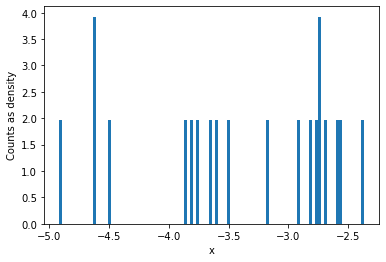

In [2]:
chosen_sig2 = 0.5
chosen_mu = -3.4

# NB! parametrization for TFP.Normal is by the standard deviation, not variance!
sampled_data = tfp.distributions.Normal(
    loc=chosen_mu, scale=np.sqrt(chosen_sig2)
).sample(20).numpy()

fig, ax = pp.subplots()
#
_ = ax.hist(sampled_data, bins=100, density=True)
ax.set_xlabel('x')
ax.set_ylabel('Counts as density')

## Prior

Build a function to compute the log of the posterior given the data. Need prior for the parameters. The model we are fitting is:

$$
\begin{align}
x &\sim N\left(\mu,\,\sigma^2\right) \\
\mu \,\Big|\, \sigma^2 &\sim N\left(\mu_0, \frac{\sigma^2}{\nu+1}\right) \\
\sigma^2 &\sim \mbox{Inv-}\chi^2\left(\nu,\,\sigma^2_0\right)=\mbox{Inv-}\Gamma\left(\frac{\nu}{2},\,\frac{\nu\sigma_0^2}{2}\right)
\end{align}
$$

A good way to think about these is that distribution of $\sigma^2$ is the one that would deduce with a sample variance of $\sigma_0^2$ obtained from $\nu_0$ degrees of freedom. i.e. if one had previously measured $\nu+1$ points from the distribution, and used one degree of freedom to fix, sample mean. Then the probability distribution for $\sigma^2$, given sample variance of $\sigma_0^2$, and assuming trivial $1/\sigma^2$ prior, would be inverse-$\chi^2$ as above.

Using the same fictitios sample, one can obtain the distribution for the mean $\mu$ given sample mean $\mu_0$ and the variance of the distribution $\nu^2$.

2021-10-30 02:21:46.771059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Text(0.5, 1.0, 'Marginal prior for $\\sigma^2$')

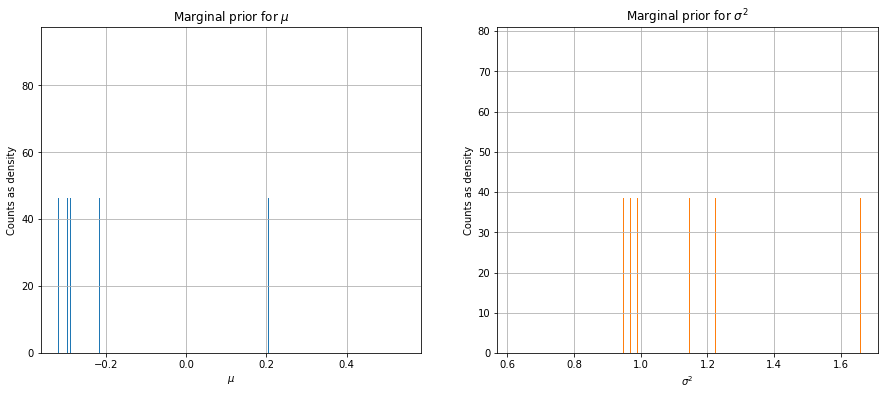

In [3]:
def get_prior_distribution(
    prior_nu: int=5,
    prior_sig2: float=1.0,
    prior_mu: float=0.0
)->tfp.distributions.JointDistribution:
    """
    Given key parameters initialize and return prior distribution for mean and variance of the normal model. The names
    for the variables are `sig2` for variance and `mu` for mean, in that order
    
    Arguments:
    ----------
        prior_nu: equivalent to degrees of freedom -1 for the prior sample of data
        prior_sig2: equivalent prior sample variance
        prior_mu: equivalent priior sample mean
        
    Returns:
    --------
        joint distribution for `sig2` and `mu`
    """
    
    tf_prior_nu = tf.constant(prior_nu, dtype=tf.float32)
    tf_prior_sig2 = tf.constant(prior_sig2, dtype=tf.float32)
    tf_prior_mu = tf.constant(prior_mu, dtype=tf.float32)
    
    prior_distr = tfp.distributions.JointDistributionNamed({
        'sig2': tfp.distributions.InverseGamma( tf_prior_nu/2., tf_prior_nu*tf_prior_sig2/2 ),
        'mu': lambda sig2: tfp.distributions.Normal( tf_prior_mu, tf.sqrt(sig2/(tf_prior_nu+1)) )
    })
    
    return prior_distr

####

prior_distr = get_prior_distribution(
    prior_nu=len(sampled_data),
    prior_sig2=1.,
    prior_mu=0.0
)
prior_samples = prior_distr.sample(len(sampled_data))

fig, (ax, ax2) = pp.subplots(1, 2, figsize=(15, 6))
#
_ = ax.hist(prior_samples['mu'].numpy(), density=True, bins=800, color=cm.tab10(0))
ax.set_xlabel('$\mu$')
ax.set_ylabel('Counts as density')
ax.grid()
ax.set_title('Marginal prior for $\mu$')
#
_ = ax2.hist(prior_samples['sig2'].numpy(), density=True, bins=800, color=cm.tab10(1))
ax2.set_xlabel('$\sigma^2$')
ax2.set_ylabel('Counts as density')
ax2.grid()
ax2.set_title('Marginal prior for $\sigma^2$')

## Likelihood and posterior

Now we are ready to define function for log-posterior probability. MCMC will then sample from it, to provide results. The posetrior will depend on prior as well as the data

In [4]:
def log_lkhd(
    mu: tf.Tensor,
    sig2: tf.Tensor,
    data: tf.Tensor=tf.constant(sampled_data)
)->tf.Tensor:
    """
    Compute likelihood for data points given mean and variance (mu, sig2). Incoming mu and sig2 can 
    be tensors. data is assumed to be a 1d tensor. Internally data extended into a [N, *] shape where
    N is the number of data points along the zeroth dimnesion of `data` argument, and * are the common
    dimensions of mu and sig2. 
    
    Assumed model is: x~N(mu, sig2)
    
    After expansion, the log_probability for all individual data points is computed, for all values in mu, sig2.
    The result is then collapsed along the zeroth dimension. The resulting [*]-dimensional tensor, with log-prob
    for all points, is returned
    
    Arguments:
    ----------
        mu: tensor of mean values
        sig2: tensor of variances, same shape as mu, this is not a multivariate model. All cells
            of mu and sig2 are simply processed in parallel
            
        data: data points, an (N,)-shaped tensor
        
    Returns:
    --------
        Tensor of log-likelihooeds
    """
    
    # reshape to have data running along the zeroth axis, with sig2 and mu running along others
    data_reshaped = tf.reshape(data, [data.shape[0], *[1 for _ in mu.shape]])
    
    # define probabilistic model
    data_model = tfp.distributions.Normal(mu, tf.sqrt(sig2))
    
    # compute log-likelihood
    log_lkhd_per_sample = data_model.log_prob(data_reshaped)
    
    # collapse along zeroth dimension, to get probability for all data points
    log_lkhd_agg = tf.reduce_sum(log_lkhd_per_sample, axis=0)
    
    return log_lkhd_agg

####

def log_post_prob(
    mu: tf.Tensor,
    sig2: tf.Tensor,
    prior_distribution: tfp.distributions.JointDistribution,
    log_lkhd_func: tp.Callable[[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor],
    data: tf.Tensor=tf.constant(sampled_data)
)->tf.Tensor:
    """
    Compute log of non-normalized posterior distribution given prior, data and likelihood
    
    Arguments:
    ----------
        mu: mean for the model - trying to fit that. tensor with arbitrary shape
        sig2: variance for the model, same as mu
        prior_distribution: Joint prior probability distribution for the data. Should take in `sig2` and 
            `mu` as inputs and return log-probability of prior beliefs (via `log_prob`)
            
        log_lkhd_func: function that takes in mu, sig2 and data, as tensors, and returns the 
            log-likelihood for all the data points, given mu and sig2. See `log_lkhd`
        data: (N,)-shaped tensor of data points for N data points
        
    Returns:
    --------
        tensor of posterior log-probabilities, that is shaped like mu and sig
    """
    
    # compute prior log-probability
    log_prior_tens = prior_distribution.log_prob(sig2=sig2, mu=mu)
    
    # compute likelihood
    log_lkhd_tens = log_lkhd_func(mu, sig2, data)
    
    # compute posterior log-prob
    log_post_tens = log_lkhd_tens + log_prior_tens
    
    return log_post_tens


####


print(
    log_post_prob(
        mu=tf.constant([[chosen_mu, 0.2, 0.7], [-0.3, 0.7, -0.9]]), 
        sig2=tf.constant([[chosen_sig2, 1.2, 3.4], [4.0, 0.9, 3.1]]),
        prior_distribution=prior_distr,
        log_lkhd_func=log_lkhd,
        data=tf.constant(sampled_data, dtype=tf.float32)
    )
)

tf.Tensor(
[[-267.4024  -133.85469  -89.8044 ]
 [ -65.79873 -216.6219   -60.13056]], shape=(2, 3), dtype=float32)


## MCMC sampling

Next, use Markov-Chain Monte Carlo to sample from log-posterior

In [5]:
######### RANDOM-WALK METROPOLIS
@tf.function(jit_compile=True)
def rwm_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100
)->tf.Tensor:
    """
    Run MCMC using basic RandomWalkMetropolis.
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and sig2 and returns log-probability for the posterior
        init_state: initial state for MCMC, list of two tensors, for mu and sig2, with shapes (K, 1) where K is the number
                    of chains
        num_burnin_steps: number of burn-in steps see `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see `tensorflow_probability.mcmc.sample_chain`
        
    Returns:
    --------
        A list of tensors ([mu, sig2]) with the results. The shape of the tensors includes number of results and 
        number of chains
    """
    
    # basic kernel
    rwm_kernel = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=log_post_func
    )
    
    # sample chain
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=rwm_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain

######### HMC

@tf.function(jit_compile=True)
def hmc_mcmc_sample(
    log_post_func: tp.Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
    init_state: tp.List[tf.Tensor],
    num_burnin_steps: int=1000,
    num_results: int=100,
    step_size: float=0.05,
    num_leapfrog_steps=3,
)->tf.Tensor:
    """
    Run MCMC using basic Hamiltonian Monte-Carlo
    
    Arguments:
    ----------
        log_post_func: function that accepts tensors for mu and sig2 and returns log-probability for the posterior
        init_state: initial state for MCMC, list of two tensors, for mu and sig2, with shapes (K, 1) where K is the number
                    of chains
        num_burnin_steps: number of burn-in steps see `tensorflow_probability.mcmc.sample_chain`
        num_results: number of results per chain see `tensorflow_probability.mcmc.sample_chain`
        step_size: size of the step for HMC
        num_leapfrog_steps: see HMC
        
    Returns:
    --------
        A list of tensors ([mu, sig2]) with the results. The shape of the tensors includes number of results and 
        number of chains
    """
    
    # basic kernel
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_post_func,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size
    )
    
    ahmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    )
    
    sampled_chain = tfp.mcmc.sample_chain(
        kernel=ahmc_kernel,
        trace_fn=None,
        current_state=init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=num_results
    )
    
    return sampled_chain

###############

sample_mean = np.mean(sampled_data)
sample_variance = np.sum((sampled_data-sample_mean)**2)/(len(sampled_data)-1)

prior_distribution = get_prior_distribution(
    prior_nu=2,# two degrees of freedom to fix sig2 and mu
    prior_sig2=sample_variance,
    prior_mu=sample_mean
)

# rig the posterior log-probability so that it only needs
# two inputs
rigged_log_post_func = lambda mu, sig2: \
    log_post_prob(
        mu=mu, 
        sig2=sig2,
        prior_distribution=prior_distribution,
        log_lkhd_func=log_lkhd,
        data=tf.constant(sampled_data, dtype=tf.float32)
    )

# set-up initial state
# list of tensors, one tensor per parameter
# here the parameters are mean and variance, so two parameters
# the shape of the tensors should be (*, 1) where the number of elements along the zeroth
# dimension determines the number of chains
chain_count = 100
# will initialize chains from prior
initial_tens_dict = prior_distribution.sample(chain_count)

mcmc_init_state = [
    tf.reshape(initial_tens_dict['mu'], shape=[chain_count, 1]),
    tf.reshape(initial_tens_dict['sig2'], shape=[chain_count, 1])
]

num_burnin_steps = 5000
samples_per_chain = 100

####
print('Running chain')

# run the chain
sampler_choice = 'hmc'

if sampler_choice == 'hmc':
    chain_list = hmc_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain,
        step_size=1.0,
        num_leapfrog_steps=3
    )
else:
    chain_list = rwm_mcmc_sample(
        log_post_func=rigged_log_post_func,
        init_state=mcmc_init_state,
        num_burnin_steps=num_burnin_steps,
        num_results=samples_per_chain
    )

print('Done')

Running chain


2021-10-30 02:21:49.695543: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x56250a6fee90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-30 02:21:49.695566: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-10-30 02:21:49.735510: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-10-30 02:21:49.802495: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Done


2021-10-30 02:21:52.121670: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Unpack into numpy for convenience

In [6]:
# unpack to dictionary
key_order = [
    'mu',
    'sig2'
]
#
results_dict = {
    key: chain_list[i_key].numpy().reshape(-1)
    for i_key, key in enumerate(key_order)
}

## Inspect results

Plot the results comparing the target values with frequentist and numerical Bayesian estimates

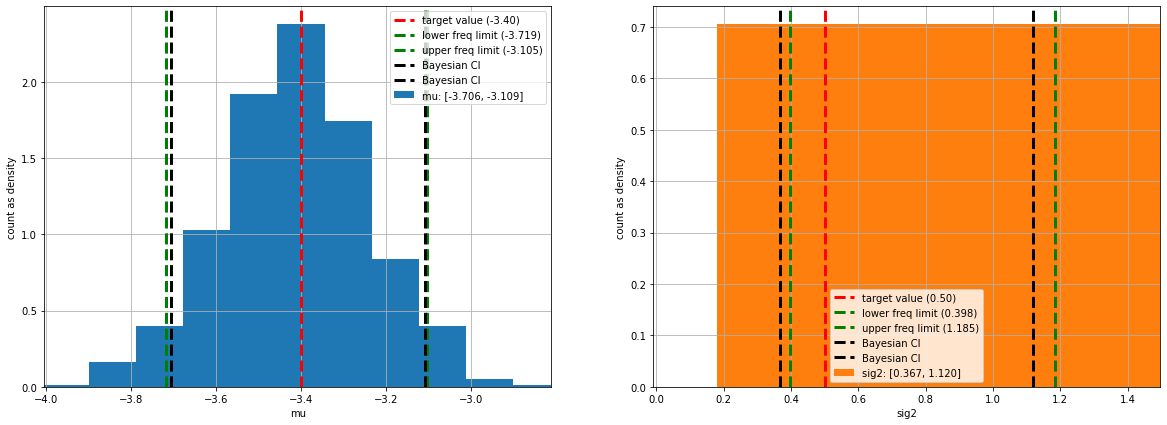

In [7]:
fig, ax_list = pp.subplots(1, len(results_dict), figsize=(10*len(results_dict), 7))

# choose confince interval
confidence_level = 0.9
lw = 3
 
# mark where the actual chosen values were
ax_list[0].axvline(
    chosen_mu, linestyle='--',
    color='r',
    label=f'target value ({chosen_mu:.2f})',
    linewidth=lw
)
#
ax_list[1].axvline(
    chosen_sig2,
    linestyle='--',
    color='r',
    label=f'target value ({chosen_sig2:.2f})',
    linewidth=lw
)

# work out the confidence interval that corresponds to frequentist statistics
sample_mean = np.mean(sampled_data)
sample_variance = np.sum((sampled_data-sample_mean)**2)/(len(sampled_data)-1)
#
t_ci_lim_norm = sp_stats.t(df=len(sampled_data)-1).ppf([(1-confidence_level)/2, 1-(1-confidence_level)/2])
freq_mu_lim = sample_mean + t_ci_lim_norm * np.sqrt(sample_variance/len(sampled_data))
#
ax_list[0].axvline(
    np.min(freq_mu_lim),
    linestyle='--',
    color='green',
    label=f'lower freq limit ({min(freq_mu_lim):.3f})',
    linewidth=lw
)
#
ax_list[0].axvline(
    np.max(freq_mu_lim),
    linestyle='--',
    color='green',
    label=f'upper freq limit ({max(freq_mu_lim):.3f})',
    linewidth=lw
)
#####################
chi2_ci_lim_norm = sp_stats.chi2(df=len(sampled_data)-1).ppf([(1-confidence_level)/2, 1-(1-confidence_level)/2])
freq_sig2_lim = (len(sampled_data)-1)*sample_variance/chi2_ci_lim_norm
#
ax_list[1].axvline(
    np.min(freq_sig2_lim),
    linestyle='--',
    color='green',
    label=f'lower freq limit ({min(freq_sig2_lim):.3f})',
    linewidth=lw
)
#
ax_list[1].axvline(
    np.max(freq_sig2_lim),
    linestyle='--',
    color='green',
    label=f'upper freq limit ({max(freq_sig2_lim):.3f})',
    linewidth=lw
)
#
  
#################
# plot results
for i_key, ((key, arr), ax) in enumerate(zip(results_dict.items(), ax_list)):
    clean_arr = arr[np.isnan(arr)==False]
    
    # compute confidence interval for the specific param
    ci_min = np.quantile(clean_arr, (1-confidence_level)/2)
    ci_max = np.quantile(clean_arr, 1-(1-confidence_level)/2)
    
    ax.hist(
        arr,
        bins=50,
        label=f'{key}: [{ci_min:.3f}, {ci_max:.3f}]',
        color=cm.tab10(i_key),
        density=True
    )
    #
    ax.axvline(ci_min, linestyle='--', color='k', label='Bayesian CI', linewidth=lw)
    ax.axvline(ci_max, linestyle='--', color='k', label='Bayesian CI', linewidth=lw)
    #
    ax.grid()
    ax.legend()
    ax.set_xlabel(f'{key}')
    ax.set_ylabel('count as density')
    
    ci_width = ci_max-ci_min
    ci_mid = (ci_max+ci_min)/2
    ax.set_xlim([ci_mid-ci_width, ci_mid+ci_width])
    
##



Simple Random Metropolis Walk/HMC seems to offer the best results so far. Next thing to try is to contrain the inputs, i.e. map them from real-valued line to something better suited.

Initially tried to initialize with deliberately shifted prior. Takes a lot of data-points to rectify this, so it is better to start from MLE.

It is note-worthy that with few thousand points there is considerable uncertainty in pinning down the variance. However, one should also note that frequentist uncretainty, based on confidence intervals for sample variance statistic, is of the same magnitude as numerical Bayesian.